Note:

Dropped  the timestamps, we only use indexes.
This also removed the large holes in the dataset, and data is not filled in anymore.

I have seen a lot of steps without lots of movement of the buy price. I then resampled the data to 1 hour intervals by using the median of every 12 steps.

**interesting enough, this has helped a lot of bringing in movement in the forecast**

why this is helping im not sure, maybe it trains the model to assume more movement than there really is?

In [3]:
%load_ext dotenv
%reload_ext dotenv
%dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [4]:
from darts.models import LightGBMModel
import pandas as pd
import numpy as np
import matplotlib
import tempfile
from darts.models import LightGBMModel
from darts.metrics import mape, rmse, mae
import mlflow
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

In [5]:
# Download source data from s3
from ml.common.folder_s3_sync import download_folder_from_s3

datapath = "../../../data/train_lightgbm/gw2/"


download_folder_from_s3(s3_folder_prefix='datasources/gw2/raw/1763399444', local_folder=datapath)

df = pd.read_csv(f'{datapath}Copper Ore.csv', delimiter=";")


Source: ost-s3/datasources/gw2/raw/1763399444
Target: ../../../data/train_lightgbm/gw2/

Found 60 files to download

⊘ +1 Agony Infusion.csv (already exists, ETag matches)
⊘ Auric Sliver.csv (already exists, ETag matches)
⊘ Bag of Coffee Beans.csv (already exists, ETag matches)
⊘ Bag of Sugar.csv (already exists, ETag matches)
⊘ Black Lion Chest.csv (already exists, ETag matches)
⊘ Bowl of Candy Corn Custard.csv (already exists, ETag matches)
⊘ Choya Spine.csv (already exists, ETag matches)
⊘ Congealed Putrescence.csv (already exists, ETag matches)
⊘ Copper Ore.csv (already exists, ETag matches)
⊘ Cup of Spiced Apple Cider.csv (already exists, ETag matches)
⊘ Elder Wood Log.csv (already exists, ETag matches)
⊘ Eye of Kormir.csv (already exists, ETag matches)
⊘ Flawless Snowflake.csv (already exists, ETag matches)
⊘ Fried Golden Dumpling.csv (already exists, ETag matches)
⊘ Glass of Buttered Spirits.csv (already exists, ETag matches)
⊘ Glob of Ectoplasm.csv (already exists, ETag matches

In [6]:
from darts import TimeSeries

def get_series_resampled(path, resample_interval):
    df = pd.read_csv(path, delimiter=";")
    value_cols = ["buy_unit_price"]

    tsdf = df[value_cols].copy()

    # Reset index to use integer index instead of timestamp
    tsdf = tsdf.reset_index(drop=True)

    tsdf = tsdf.groupby(tsdf.index // resample_interval).median()


    # Create TimeSeries with integer index
    series = TimeSeries.from_dataframe(tsdf, value_cols=value_cols)


    return series

sample = get_series_resampled(f"{datapath}Copper Ore.csv", resample_interval=12)

<Axes: xlabel='time'>

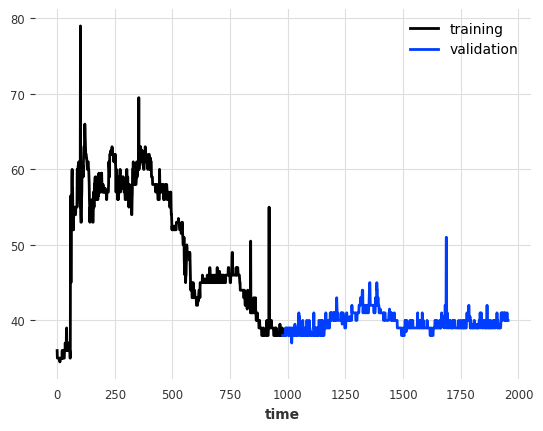

In [7]:
def train_val_split(series, split_percentage):
    train, val = series.split_after(split_percentage)
    return train, val

samples = get_series_resampled(f"{datapath}Copper Ore.csv", resample_interval=12)
samplet, samplev = train_val_split(samples, split_percentage=0.5)
samplet.plot(label="training")
samplev.plot(label="validation")

In [8]:
def train_lightgbm_model(item="Jute Scrap.csv",run_name="lightgbm", resample_interval=12, split_percentage=0.8,
                         lags=256, output_chunk_length=256, mlflow_nested_run = False):
    """
    Train a LightGBM model for time series forecasting.

    Parameters:
    -----------
    item : str
        Name of the CSV file to load (e.g., "Jute Scrap.csv")
    resample_interval : int
        Interval for resampling the data
    split_percentage : float
        Percentage for train/validation split (0.0 to 1.0)
    lags : int
        Number of lags to use in the model
    output_chunk_length : int
        Output chunk length for the model

    Returns:
    --------
    tuple
        (model, train, val, pred, metrics_dict)
    """


    with mlflow.start_run(run_name=run_name, nested=mlflow_nested_run):
        # Load and prepare data
        series_sampled = get_series_resampled(f"{datapath}{item}", resample_interval=resample_interval)
        train, val = train_val_split(series_sampled, split_percentage)
        prediction_horizon = len(val)

        # Model parameters
        model_params = {
            "lags": lags,
            "lags_past_covariates": None,
            "lags_future_covariates": None,
            "output_chunk_length": output_chunk_length,
            "force_row_wise": True,
            "device": "gpu",
        }

        # Log parameters
        mlflow.log_params({
            "resample_interval": resample_interval,
            "train_test_split": split_percentage,
            "prediction_horizon": prediction_horizon,
            **model_params
        })

        # Train model
        model = LightGBMModel(**model_params)
        model.fit(train)

        # Make predictions
        pred = model.predict(n=prediction_horizon)

        # Calculate metrics
        val_short = val[:prediction_horizon]
        mape_score = mape(val_short, pred)
        rmse_score = rmse(val_short, pred)
        mae_score = mae(val_short, pred)

        # Log metrics
        metrics_dict = {
            "mape": mape_score,
            "rmse": rmse_score,
            "mae": mae_score
        }
        mlflow.log_metrics(metrics_dict)

        # Save and log artifacts
        with tempfile.TemporaryDirectory() as tmpdir:
            train.to_csv(f"{tmpdir}/train.csv")
            val.to_csv(f"{tmpdir}/val.csv")
            pred.to_csv(f"{tmpdir}/pred.csv")
            mlflow.log_artifacts(tmpdir, artifact_path="series")

            # Create and log the prediction plot
            fig, ax = plt.subplots(figsize=(12, 6))
            train[-200:].plot(label="training", ax=ax)
            val_short.plot(label="validation", ax=ax)
            pred.plot(label="prediction", ax=ax)
            ax.legend()
            ax.set_title(f"Model Predictions vs Actual Values - {item}")

            # Log the figure directly without saving to disk
            mlflow.log_figure(fig, "prediction_plot.png")
            plt.close(fig)

        # Log model
        mlflow.sklearn.log_model(model.model, "lightgbm_model")

        # Log additional info
        mlflow.set_tags({
            "dataset": item.removesuffix(".csv"),
            "model_type": "LightGBM",
            "framework": "Darts"
        })

        # Print results
        print(f"MAPE: {mape_score:.2f}%")
        print(f"RMSE: {rmse_score:.2f}")
        print(f"MAE: {mae_score:.2f}")

        # Plot results
        train[-200:].plot(label="training")
        val_short.plot(label="validation")
        pred.plot(label="prediction")

        return model, train, val, pred, metrics_dict

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7332
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 256
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 256 dense feature groups (0.26 MB) transferred to GPU in 0.006360 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 44.252372
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7332
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 256
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 

2025/11/21 11:09:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/21 11:09:42 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/21 11:09:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 8.99%
RMSE: 4.28
MAE: 3.66
🏃 View run lightgbm at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/9/runs/ca42fffbe9164fa7a71145f144740dfe
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/9
Successfully trained model for Gold Ore.csv
🏃 View run lightgbm_comparison at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/9/runs/263523a55081436b972618be17667cc1
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/9


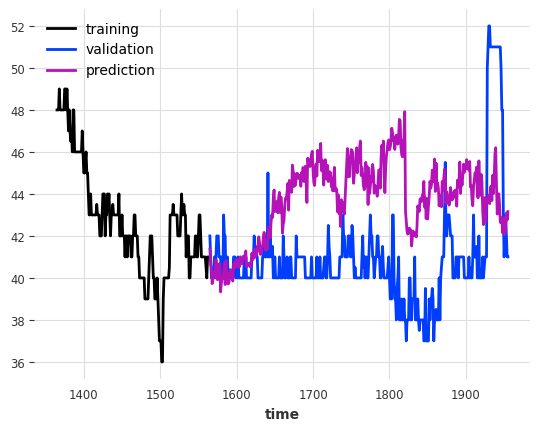

In [9]:
import mlflow
items = [
    "Gold Ore.csv",
]
mlflow.set_experiment("lightgbm")

with mlflow.start_run(run_name="lightgbm_comparison") as run:
    for item in items:
        try:
            model, train, val, pred, metrics = train_lightgbm_model(item=item,resample_interval=6,
             mlflow_nested_run=True)
            print(f"Successfully trained model for {item}")
        except Exception as e:
            print(f"Error training model for {item}: {e}")

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 10743
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 256
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 256 dense feature groups (0.26 MB) transferred to GPU in 0.007252 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 45.921727
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 10743
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 256
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info

2025/11/20 22:26:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 22:27:01 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/20 22:27:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 2.21%
RMSE: 1.31
MAE: 0.89
🏃 View run lightgbm at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/9/runs/98b52d72007e41c494f88f3628a3db77
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/9
Successfully trained model for Copper Ore.csv
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12479
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 256
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 256 dense feature groups (0.26 MB) transferred to GPU in 0.001396 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 107.762334
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12479
[

2025/11/20 22:27:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 22:28:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/20 22:28:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 7.09%
RMSE: 10.39
MAE: 7.69
🏃 View run lightgbm at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/9/runs/ae7e5013e4f94b7ca2f9b9f257dddde1
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/9
Successfully trained model for Iron Ore.csv
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7332
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 256
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 256 dense feature groups (0.26 MB) transferred to GPU in 0.001430 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 44.252372
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7332
[Ligh

2025/11/20 22:28:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 22:29:01 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/20 22:29:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 9.01%
RMSE: 4.28
MAE: 3.67
🏃 View run lightgbm at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/9/runs/49148da534804198bfe9df4517c7fe1e
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/9
Successfully trained model for Gold Ore.csv
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11554
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 256
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 256 dense feature groups (0.26 MB) transferred to GPU in 0.001617 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 97.217268
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11554
[Lig

2025/11/20 22:29:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 22:29:59 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/20 22:29:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 11.21%
RMSE: 13.23
MAE: 10.17
🏃 View run lightgbm at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/9/runs/85eb61f1379e4732b47774c1cd450576
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/9
Successfully trained model for Gold Ingot.csv
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4759
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 256
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 256 dense feature groups (0.26 MB) transferred to GPU in 0.003487 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 16.737666
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4759
[

2025/11/20 22:30:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 22:30:47 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/20 22:30:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 14.41%
RMSE: 3.46
MAE: 2.77
🏃 View run lightgbm at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/9/runs/4ac10bdd67bd4a4cb34fb7b94ffbb6d9
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/9
Successfully trained model for Silver Ore.csv
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 16521
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 256
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 256 dense feature groups (0.26 MB) transferred to GPU in 0.001311 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 206.051233
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 16521

2025/11/20 22:31:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 22:31:48 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/20 22:31:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 4.76%
RMSE: 14.66
MAE: 10.51
🏃 View run lightgbm at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/9/runs/2ec3d13c815144a881a8747148dc6196
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/9
Successfully trained model for Snowflake.csv
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 17334
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 256
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 256 dense feature groups (0.26 MB) transferred to GPU in 0.001462 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 53.733397
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 17334


2025/11/20 22:32:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 22:32:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/20 22:32:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 3.84%
RMSE: 1.89
MAE: 1.56
🏃 View run lightgbm at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/9/runs/52904d98692d4d41bd54c37b85a94926
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/9
Successfully trained model for Mithril Ore.csv
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1792
[LightGBM] [Info] Number of data points in the train set: 1051, number of used features: 256
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 256 dense feature groups (0.13 MB) transferred to GPU in 0.004285 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 7.772598
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1792
[Lig

2025/11/20 22:33:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 22:33:35 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/20 22:33:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 9.57%
RMSE: 0.92
MAE: 0.70
🏃 View run lightgbm at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/9/runs/6f1c47b3fc7c430d998db9b878338345
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/9
Successfully trained model for Bag of Sugar.csv
🏃 View run lightgbm_comparison at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/9/runs/da7266f3450544df9b16f783ebdb47c5
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/9


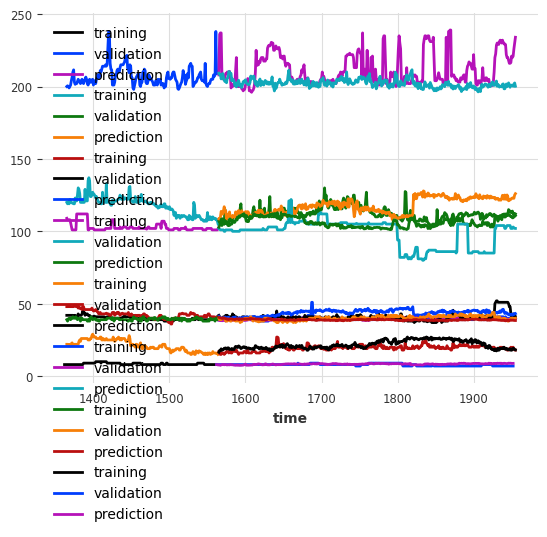

In [7]:
import mlflow
items = [
    "Copper Ore.csv",
    "Iron Ore.csv",
    "Gold Ore.csv",
    "Gold Ingot.csv",
    "Silver Ore.csv",
    "Snowflake.csv",
    "Mithril Ore.csv",
    "Bag of Sugar.csv"
]
mlflow.set_experiment("lightgbm")

with mlflow.start_run(run_name="lightgbm_comparison") as run:
    for item in items:
        try:
            model, train, val, pred, metrics = train_lightgbm_model(item=item, mlflow_nested_run=True)
            print(f"Successfully trained model for {item}")
        except Exception as e:
            print(f"Error training model for {item}: {e}")